In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import torch as tch
import xgboost as xgb
import sklearn.feature_selection as skl_ft_sel

from time import time
from copy import deepcopy
from google.colab import drive

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, recall_score, matthews_corrcoef
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

#drive.mount('/content/drive')

In [ ]:
train_data = pd.read_csv("./train_imperson_without4n7_balanced_data.csv")
test_data = pd.read_csv("./test_imperson_without4n7_balanced_data.csv")

print(train_data.shape)
print(test_data.shape)

(97044, 153)
(40158, 153)


In [ ]:
X = train_data.drop(columns="155")
y = train_data["155"]

X_test = test_data.drop(columns="155")
y_test = test_data["155"]

print(y.value_counts())
print(y_test.value_counts())

1    48522
0    48522
Name: 155, dtype: int64
1    20079
0    20079
Name: 155, dtype: int64


# Exploratory Data Analysis

## 1. Data Quality

- Missing values
- Data Types

In [ ]:
# To check missing number first we check null values per column by adding them at column level.
#  If the sum of all these values is more than zero, that means that there is one or more null values.

print(train_data.isnull().sum())
print(f"\nNumber of null values in all data: {train_data.isnull().sum().sum()}")

1      0
2      0
3      0
5      0
6      0
      ..
151    0
152    0
153    0
154    0
155    0
Length: 153, dtype: int64

Number of null values in all data: 0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97044 entries, 0 to 97043
Columns: 153 entries, 1 to 155
dtypes: float64(48), int64(105)
memory usage: 113.3 MB


Correlation between features

In [ ]:
corr_matrix = X.corr()
corr_matrix

,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,1.000000,1.000000,-0.077632,-0.077632,NaN,NaN,NaN,NaN,-0.180590,-0.180590,-0.180590,NaN,-0.180590,NaN,-0.180590,NaN,NaN,NaN,NaN,NaN,-0.180590,NaN,NaN,-0.180590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.016595,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.001040,0.370106,0.018876,0.389842,0.145212,0.349219,0.045363,NaN,0.065585,0.231718,0.231551,0.229828,0.231718,0.231718,NaN,NaN,0.000014,NaN,NaN,NaN,NaN,0.000014,NaN,-0.092144,-0.030381,-0.092001,-0.030389,0.004057,-0.087787,-0.087787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.097357
6,NaN,NaN,NaN,1.000000,1.000000,-0.077632,-0.077632,NaN,NaN,NaN,NaN,-0.180590,-0.180590,-0.180590,NaN,-0.180590,NaN,-0.180590,NaN,NaN,NaN,NaN,NaN,-0.180590,NaN,NaN,-0.180590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.016595,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.001040,0.370106,0.018876,0.389842,0.145212,0.349219,0.045363,NaN,0.065585,0.231718,0.231551,0.229828,0.231718,0.231718,NaN,NaN,0.000014,NaN,NaN,NaN,NaN,0.000014,NaN,-0.092144,-0.030381,-0.092001,-0.030389,0.004057,-0.087787,-0.087787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.097357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Identify and removed features without variance

In [ ]:
# Let's identify variables wit ha single value

no_variance_variables = []

for col in X.columns:
  if X[col].value_counts().values.shape[0] == 1:
    present_single_value = X[col].value_counts().index.values[0]
    print(f"Variable {col} has single value: {present_single_value}")
    no_variance_variables.append(col)


Variable 1 has single value: 0
Variable 2 has single value: 0
Variable 3 has single value: 0
Variable 10 has single value: 0
Variable 11 has single value: 0
Variable 12 has single value: 0
Variable 13 has single value: 0
Variable 17 has single value: 1
Variable 19 has single value: 0
Variable 21 has single value: 0
Variable 22 has single value: 0
Variable 23 has single value: 0
Variable 24 has single value: 0
Variable 25 has single value: 0
Variable 27 has single value: 0
Variable 28 has single value: 0
Variable 30 has single value: 0
Variable 31 has single value: 0
Variable 32 has single value: 0
Variable 33 has single value: 0
Variable 34 has single value: 0
Variable 35 has single value: 0
Variable 36 has single value: 0
Variable 37 has single value: 0
Variable 39 has single value: 0
Variable 40 has single value: 0
Variable 41 has single value: 0
Variable 42 has single value: 0
Variable 44 has single value: 0
Variable 45 has single value: 0
Variable 46 has single value: 0
Variable 49

In [ ]:
# We proceed to remove those variables from out dataset:

X_cleaned = X.drop(columns=no_variance_variables)

print(f"New shape of our train data set: {X_cleaned.shape}")

New shape of our train data set: (97044, 78)


In [ ]:
X_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97044 entries, 0 to 97043
Data columns (total 78 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   5       97044 non-null  float64
 1   6       97044 non-null  float64
 2   8       97044 non-null  float64
 3   9       97044 non-null  float64
 4   14      97044 non-null  int64  
 5   15      97044 non-null  int64  
 6   16      97044 non-null  int64  
 7   18      97044 non-null  int64  
 8   20      97044 non-null  int64  
 9   26      97044 non-null  int64  
 10  29      97044 non-null  int64  
 11  38      97044 non-null  float64
 12  43      97044 non-null  int64  
 13  47      97044 non-null  float64
 14  48      97044 non-null  float64
 15  50      97044 non-null  int64  
 16  51      97044 non-null  int64  
 17  52      97044 non-null  int64  
 18  61      97044 non-null  float64
 19  62      97044 non-null  int64  
 20  64      97044 non-null  float64
 21  66      97044 non-null  float64
 22

Correlation matrix once removed features without variance

In [ ]:
corr_matrix = X_cleaned.corr()
corr_matrix

,5,6,8,9,14,15,16,18,20,26,29,38,43,47,48,50,51,52,61,62,64,66,67,68,70,71,72,73,75,76,77,78,79,80,82,83,84,86,88,89,90,93,94,97,98,104,105,106,107,108,109,110,111,112,113,117,118,119,120,121,122,123,125,126,127,128,129,130,133,138,140,141,142,143,144,145,146,154
5,1.000000,1.000000,-0.077632,-0.077632,-0.180590,-0.180590,-0.180590,-0.180590,-0.180590,-0.180590,-0.180590,-0.016595,-0.180590,-0.122957,-0.180574,0.127856,-0.133689,-0.180590,-0.127728,-0.180590,-0.251799,-0.188450,-0.036251,-0.106597,-0.064025,-0.005822,-0.004746,-0.119754,-0.060531,-0.021790,-0.034882,0.012135,0.010718,0.016370,0.025829,-0.001355,-0.001690,-0.002141,-0.001982,-0.180590,0.362618,0.285425,0.189182,0.000014,0.361162,-0.007076,-0.000982,-0.006333,0.258671,0.379961,-0.003075,-0.064028,-0.001836,-0.015070,-0.000065,-0.001040,0.370106,0.018876,0.389842,0.145212,0.349219,0.045363,0.065585,0.231718,0.231551,0.229828,0.231718,0.231718,0.000014,0.000014,-0.092144,-0.030381,-0.092001,-0.030389,0.004057,-0.087787,-0.087787,-0.097357
6,1.000000,1.000000,-0.077632,-0.077632,-0.180590,-0.180590,-0.180590,-0.180590,-0.180590,-0.180590,-0.180590,-0.016595,-0.180590,-0.122957,-0.180574,0.127856,-0.133689,-0.180590,-0.127728,-0.180590,-0.251799,-0.188450,-0.036251,-0.106597,-0.064025,-0.005822,-0.004746,-0.119754,-0.060531,-0.021790,-0.034882,0.012135,0.010718,0.016370,0.025829,-0.001355,-0.001690,-0.002141,-0.001982,-0.180590,0.362618,0.285425,0.189182,0.000014,0.361162,-0.007076,-0.000982,-0.006333,0.258671,0.379961,-0.003075,-0.064028,-0.001836,-0.015070,-0.000065,-0.001040,0.370106,0.018876,0.389842,0.145212,0.349219,0.045363,0.065585,0.231718,0.231551,0.229828,0.231718,0.231718,0.000014,0.000014,-0.092144,-0.030381,-0.092001,-0.030389,0.004057,-0.087787,-0.087787,-0.097357
8,-0.077632,-0.077632,1.000000,1.000000,0.007557,0.007557,0.007557,0.007557,0.007557,0.007557,0.007557,-0.359139,0.007557,0.807290,0.007589,-0.676692,0.677076,0.007557,0.239637,0.007557,0.462260,0.269971,0.243419,0.326935,-0.001105,-0.316518,-0.007841,0.307936,0.003248,0.010608,0.047698,-0.005754,-0.065066,0.015963,0.457020,-0.002399,-0.004039,-0.004698,-0.003037,0.007557,-0.103971,-0.084178,-0.038959,-0.000625,-0.104025,-0.017863,-0.002166,-0.014414,-0.044612,-0.101318,-0.012635,-0.132710,-0.007541,-0.033970,-0.002805,-0.003697,-0.107068,-0.011648,-0.102398,-0.022350,-0.052116,-0.007589,-0.008470,-0.043529,-0.043511,-0.043493,-0.043529,-0.043529,-0.000625,-0.000625,0.402628,-0.038433,0.413034,-0.035072,-0.002107,0.975838,0.975838,0.998035
9,-0.077632,-0.077632,1.000000,1.000000,0.007557,0.007557,0.007557,0.007557,0.007557,0.007557,0.007557,-0.359139,0.007557,0.807290,0.007589,-0.676692,0.677076,0.007557,0.239637,0.007557,0.462260,0.269971,0.243419,0.326935,-0.001105,-0.316518,-0.007841,0.307936,0.003248,0.010608,0.047698,-0.005754,-0.065066,0.015963,0.457020,-0.002399,-0.004039,-0.004698,-0.003037,0.007557,-0.103971,-0.084178,-0.038959,-0.000625,-0.104025,-0.017863,-0.002166,-0.014414,-0.044612,-0.101318,-0.012635,-0.132710,-0.007541,-0.033970,-0.002805,-0.003697,-0.107068,-0.011648,-0.102398,-0.022350,-0.052116,-0.007589,-0.008470,-0.043529,-0.043511,-0.043493,-0.043529,-0.043529,-0.000625,-0.000625,0.402628,-0.038433,0.413034,-0.035072,-0.002107,0.975838,0.975838,0.998035
14,-0.180590,-0.180590,0.007557,0.007557,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.095629,1.000000,0.009107,0.999883,0.022557,0.009590,1.000000,-0.047645,1.000000,0.039140,0.030606,0.002578,0.022407,0.004200,0.010575,0.000473,0.022692,0.004851,0.001912,0.003555,-0.002331,-0.001517,-0.001198,0.001658,0.000067,0.000116,0.000134,0.000087,1.000000,0.004537,0.003487,0.002500,0.000047,0.004504,0.000865,0.000077,0.000433,0.002216,0.004320,0.000892,0.003774,0.000313,0.001020,0.000082,0.000105,-0.046763,0.000429,-0.057232,0.001006,0.002687,0.000366,0.000571,0.002183,0.002182,0.002163,0.002183,0.002183,0.000047,0.000047,0.015448,0.001530,0.014653,0.001348,0.000383,0.006665,0.006665,0.007292
...,...,...,...,.

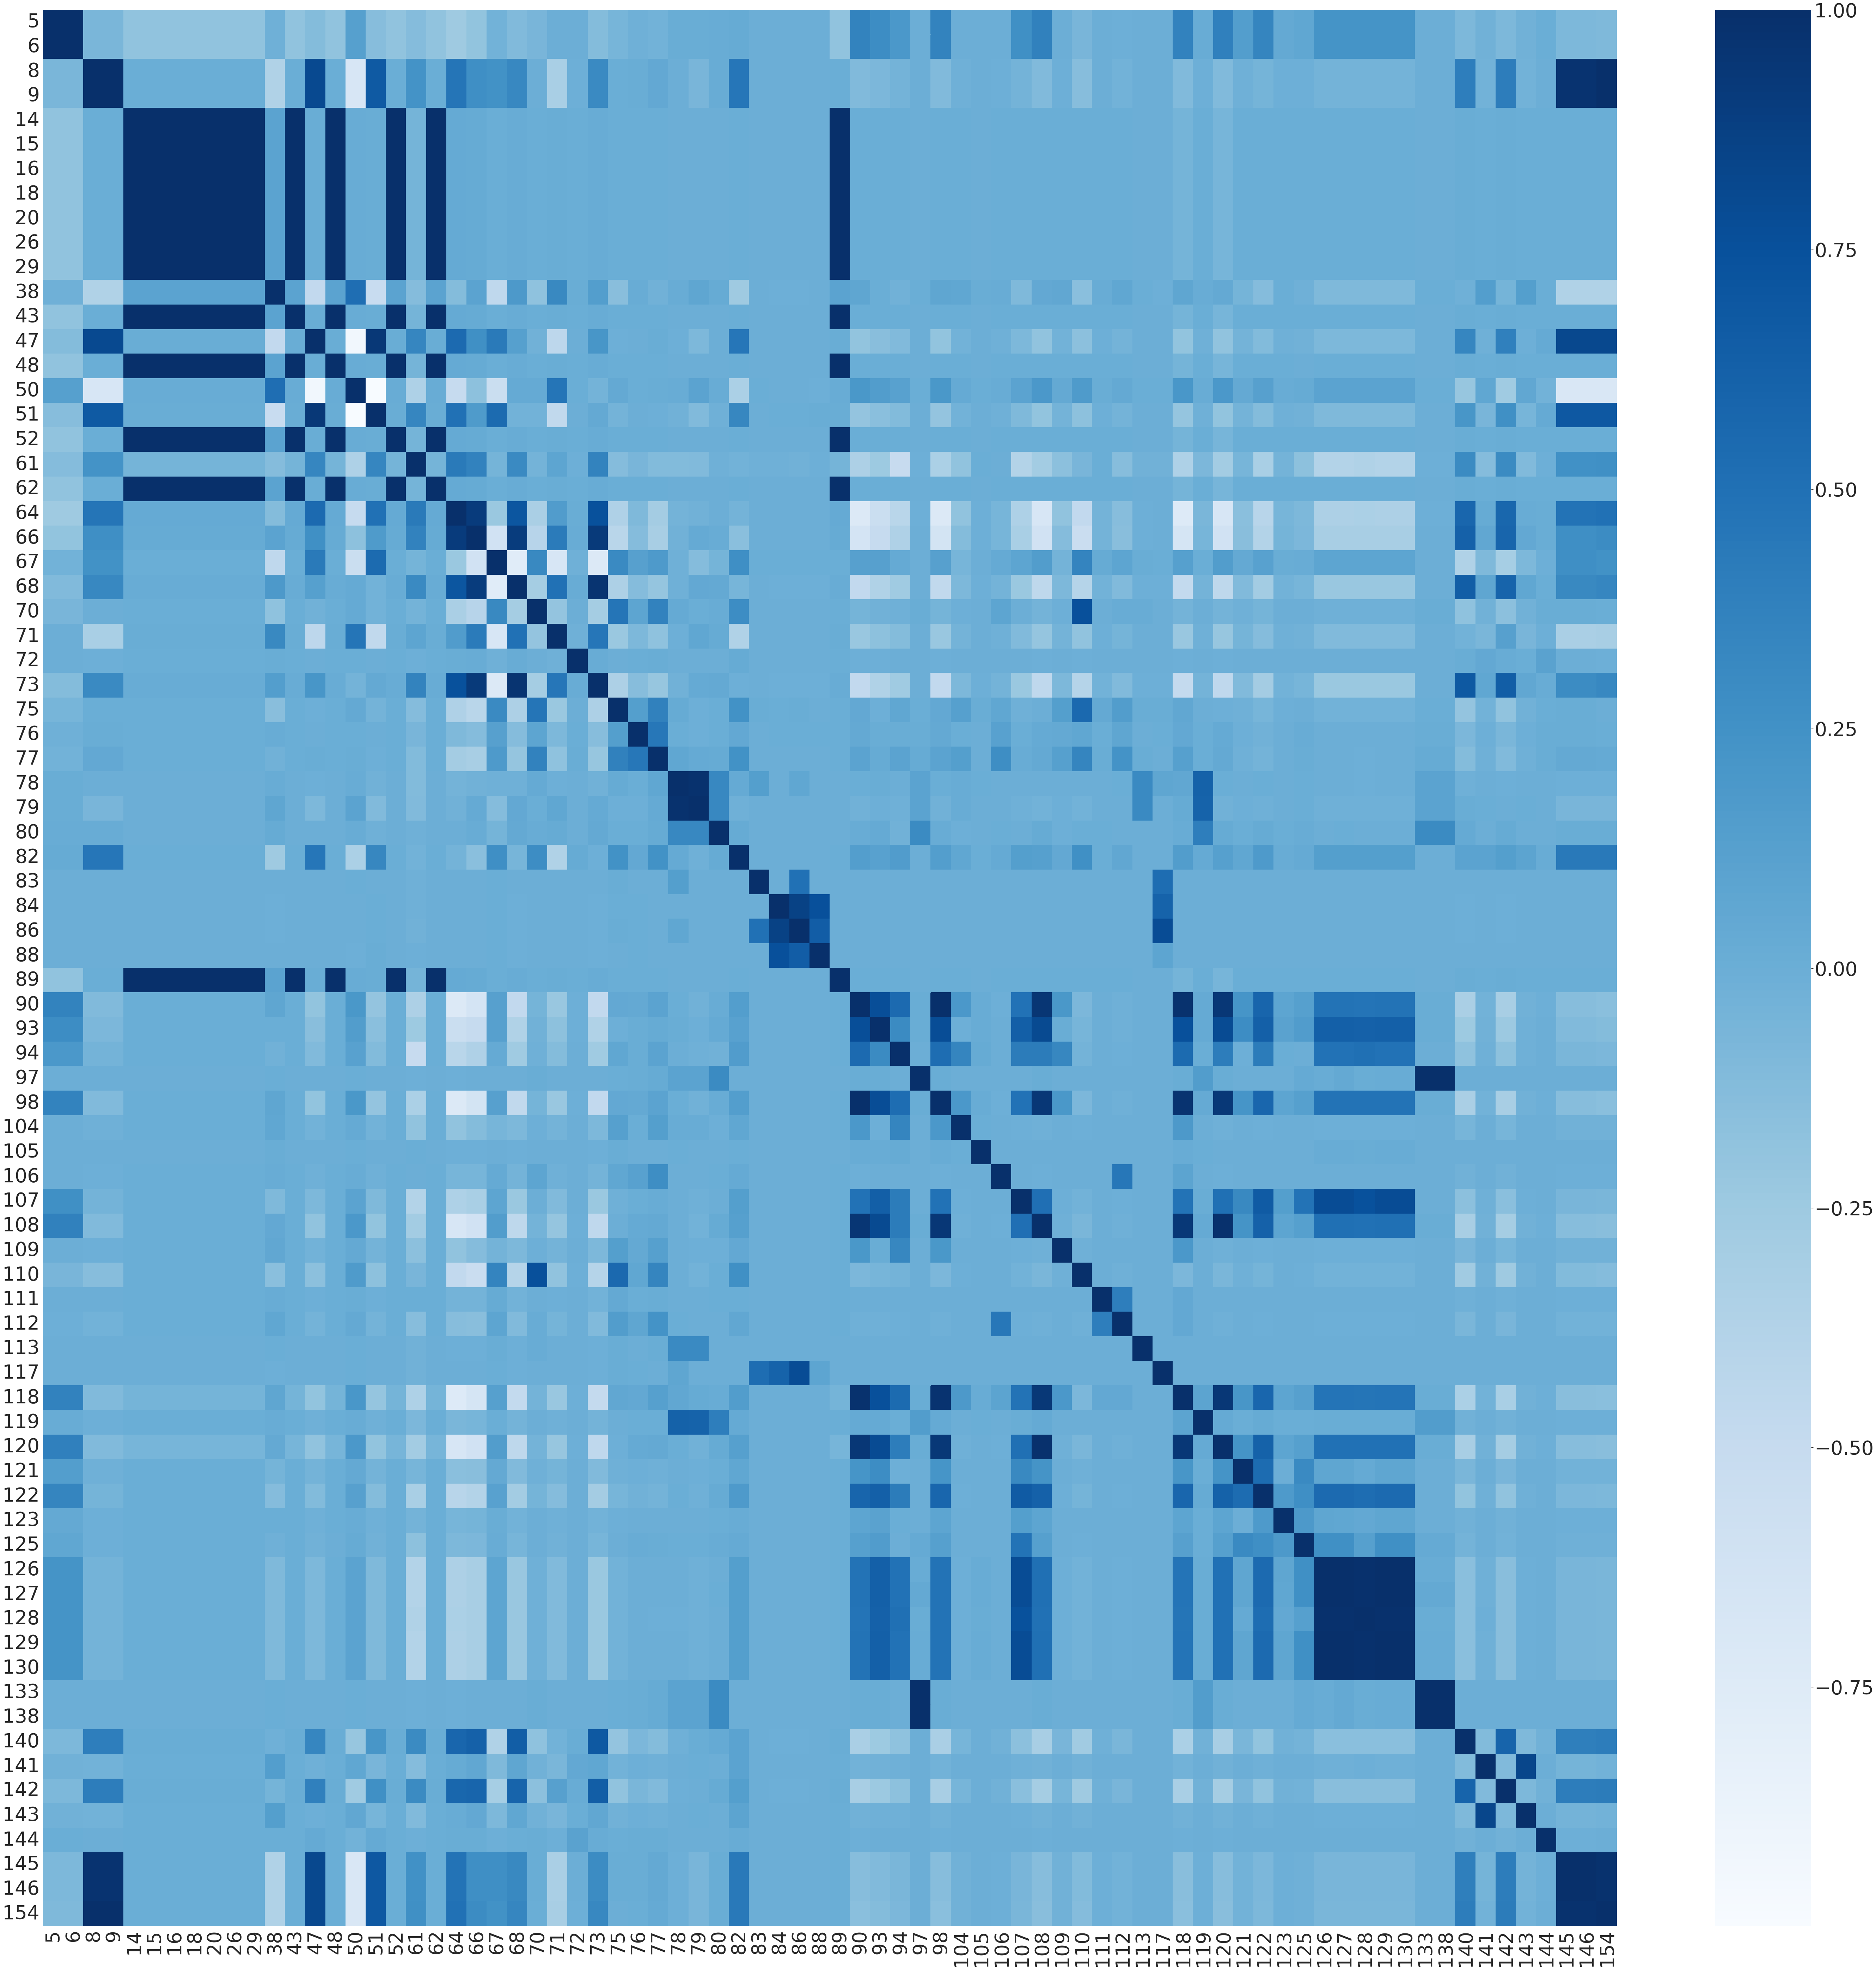

In [ ]:
# building a heatmap plot


fig = plt.figure(figsize=(100,100))
sns.set(font_scale=5)
sns.heatmap(corr_matrix, cbar=True, cmap='Blues')

fig.savefig('correlation_heatmap.png')

In [ ]:
correlated_variables = corr_matrix.unstack().sort_values()

print(correlated_variables)

51   50    -0.999483
50   51    -0.999483
47   50    -0.933435
50   47    -0.933435
68   67    -0.769364
              ...   
130  129    1.000000
     126    1.000000
126  130    1.000000
     129    1.000000
129  126    1.000000
Length: 6084, dtype: float64


In [ ]:
FINAL_HIGH_CORR_PAIRS = []
FINAL_HIGH_CORR_VALUES = []
CORR_THRESHOLD = .65

high_corr_variables = correlated_variables.loc[(correlated_variables > CORR_THRESHOLD) | (correlated_variables < -CORR_THRESHOLD)]

for variable_pair, corr_value in zip(high_corr_variables.index.values, high_corr_variables.values):
  if not variable_pair[0] == variable_pair[1]: # We remove same variable corr as this makes no sense
    ordered_pair = list(variable_pair)
    ordered_pair.sort()
    if ordered_pair not in FINAL_HIGH_CORR_PAIRS:
      FINAL_HIGH_CORR_PAIRS.append(ordered_pair)
      FINAL_HIGH_CORR_VALUES.append(corr_value)
      print(f"Variables {ordered_pair} --> Correlation:  {corr_value}")


Variables ['50', '51'] --> Correlation:  -0.9994832457688536
Variables ['47', '50'] --> Correlation:  -0.9334346418097027
Variables ['67', '68'] --> Correlation:  -0.7693637436486722
Variables ['118', '64'] --> Correlation:  -0.74009681492893
Variables ['64', '90'] --> Correlation:  -0.7253475461475655
Variables ['67', '73'] --> Correlation:  -0.7221874608060208
Variables ['64', '98'] --> Correlation:  -0.72045073971238
Variables ['145', '50'] --> Correlation:  -0.6940529797083406
Variables ['146', '50'] --> Correlation:  -0.6940529797083406
Variables ['154', '50'] --> Correlation:  -0.6873367679406522
Variables ['67', '71'] --> Correlation:  -0.6786201442818512
Variables ['120', '64'] --> Correlation:  -0.6780982702588291
Variables ['50', '8'] --> Correlation:  -0.6766919941536748
Variables ['50', '9'] --> Correlation:  -0.6766919941536748
Variables ['108', '64'] --> Correlation:  -0.6724053947349399
Variables ['118', '66'] --> Correlation:  -0.6544792369882546
Variables ['86', '88'] 

Correlation between features and target.

In [ ]:
target_vs_features_corr = train_data.drop(columns=no_variance_variables).corr()["155"]
target_vs_features_corr

5      0.058410
6      0.058410
8     -0.438183
9     -0.438183
14     0.014712
         ...   
144   -0.026030
145   -0.453058
146   -0.453058
154   -0.434536
155    1.000000
Name: 155, Length: 79, dtype: float64

In [ ]:
CORR_THRESHOLD = .65

target_vs_features_high_correlations = target_vs_features_corr.loc[
  (target_vs_features_corr > CORR_THRESHOLD) | (target_vs_features_corr < -CORR_THRESHOLD)
]
target_vs_features_high_correlations

50     0.652165
51    -0.651828
67    -0.838937
71     0.708561
155    1.000000
Name: 155, dtype: float64

# Experiments



In [ ]:

def create_new_features_dataframe(feature_numpy_array, column_labbel, norm=False):
  if norm:
    input_ = normalize(feature_numpy_array)
  else:
    input_ = feature_numpy_array

  df = pd.DataFrame(input_)
  df.columns = ["{}_{}".format(column_labbel, idx) for idx, _ in enumerate(df.columns)]

  return df


def evaluate_results(y, y_pred):
  """
  Evaluation Metrics:
  - Accuracy (Acc)
  - Recall
  - False Alarm (FAR): FP / N
  - Type II Error: FN / (FN + TP)
  - F1
  - MCC
  """
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

  acc = accuracy_score(y, y_pred)
  recall = recall_score(y, y_pred)
  far = fp / (tn + fn)
  type_ii_err = fp / (fp + tn)
  f1 = f1_score(y, y_pred)
  mcc = matthews_corrcoef(y, y_pred)
  roc_auc = roc_auc_score(y, y_pred)

  print(f"Confussion Matrix:")
  print(f"\t{tp}\t{fn}")
  print(f"\t{fp}\t{tn}")

  print(f"Accuracy: {acc}")
  print(f"Detection Rate: {recall}")
  print(f"False Alarm Rate: {far}")
  print(f"Type II Error: {type_ii_err}")
  print(f"F1: {f1}")
  print(f"MCC: {mcc}")
  print(f"Roc auc: {roc_auc}")

  return dict(
      accuracy=acc,
      recall=recall,
      far=far,
      type_ii_err=type_ii_err,
      f1=f1,
      mcc=mcc,
      roc_auc=roc_auc,
  )


from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=1)

for train_idx, val_idx in sss.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

overall_results = []

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(77635, 152)
(77635,)
(19409, 152)
(19409,)


In [ ]:
y_train.value_counts()

0    38818
1    38817
Name: 155, dtype: int64

In [ ]:
y_val.value_counts()

1    9705
0    9704
Name: 155, dtype: int64



## Baseline: No feature generation/selection + Simple XGBoost Classifier
 


Train Dataset

Confussion Matrix:
	38802	15
	87	38731
Accuracy: 0.9986861595929671
Detection Rate: 0.9996135713733674
False Alarm Rate: 0.002245393072833325
Type II Error: 0.0022412282961512702
F1: 0.9986873600494169
MCC: 0.9973740349361632
Roc auc: 0.9986861715386081

Val Dataset

Confussion Matrix:
	9702	3
	28	9676
Accuracy: 0.9984028028234324
Detection Rate: 0.9996908809891808
False Alarm Rate: 0.002892860832730654
Type II Error: 0.0028854080791426216
F1: 0.9984049395420632
MCC: 0.9968089128407526
Roc auc: 0.9984027364550191

SUMMARY
            classifier feature_gen  ...     train       val
accuracy       xgboost              ...  0.998686  0.998403
recall         xgboost              ...  0.999614  0.999691
far            xgboost              ...  0.002245  0.002893
type_ii_err    xgboost              ...  0.002241  0.002885
f1             xgboost              ...  0.998687  0.998405
mcc            xgboost              ...  0.997374  0.996809
roc_auc        xgboost              

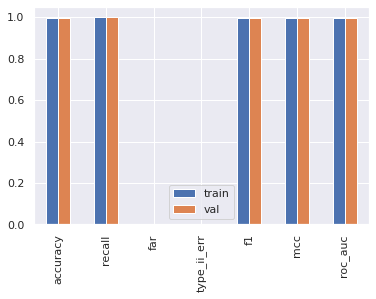

In [ ]:
hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  random_state=42
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = ""
performance["feature_sel"] = ""
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)
model.fit(X_train, y_train)

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train));
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val));

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}_overfited.jpg',
    bbox_inches='tight',
)


##  No feature generation/selection + Linear booster XGBoost Classifier


Train Dataset

Confussion Matrix:
	35930	2887
	2682	36136
Accuracy: 0.9282668899336639
Detection Rate: 0.9256253703274339
False Alarm Rate: 0.06872869845988264
Type II Error: 0.06909165850893915
F1: 0.9280760438595357
MCC: 0.8565457148114757
Roc auc: 0.9282668559092473

Val Dataset

Confussion Matrix:
	8978	727
	644	9060
Accuracy: 0.92936266680406
Detection Rate: 0.9250901597114889
False Alarm Rate: 0.06580157351588842
Type II Error: 0.0663643858202803
F1: 0.9290629689036062
MCC: 0.8587568047403182
Roc auc: 0.9293628869456043

SUMMARY
            classifier feature_gen  ...     train       val
accuracy       xgboost              ...  0.928267  0.929363
recall         xgboost              ...  0.925625  0.925090
far            xgboost              ...  0.068729  0.065802
type_ii_err    xgboost              ...  0.069092  0.066364
f1             xgboost              ...  0.928076  0.929063
mcc            xgboost              ...  0.856546  0.858757
roc_auc        xgboost              ..

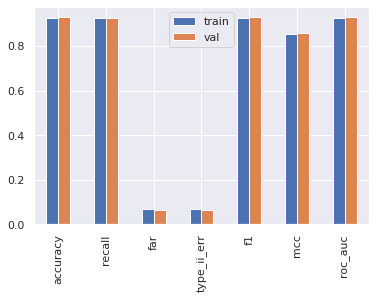

In [ ]:
hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  booster='gblinear', # <------------- linear booster
  random_state=42
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = ""
performance["feature_sel"] = ""
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)
model.fit(X_train, y_train)

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train));
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val));

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

##  PCA features generation + Linear booster XGBoost Classifier

In [ ]:
pca = PCA(n_components=10, random_state=1)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

X_train_pca = create_new_features_dataframe(X_train_pca, 'pca')
X_val_pca = create_new_features_dataframe(X_val_pca, 'pca')

print('Train Set shape')
print(X_train_pca.shape)
print('Validation Set shape')
print(X_val_pca.shape)


Train Set shape
(77635, 10)
Validation Set shape
(19409, 10)



Train Dataset

Confussion Matrix:
	35798	3019
	2107	36711
Accuracy: 0.9339730791524441
Detection Rate: 0.9222247984130665
False Alarm Rate: 0.053032972564812486
Type II Error: 0.05427894275851409
F1: 0.9331873517374418
MCC: 0.8681857683165144
Roc auc: 0.9339729278272761

Val Dataset

Confussion Matrix:
	8940	765
	503	9201
Accuracy: 0.9346694832294297
Detection Rate: 0.9211746522411128
False Alarm Rate: 0.0504716034517359
Type II Error: 0.05183429513602638
F1: 0.9337789847503656
MCC: 0.8696561423987491
Roc auc: 0.9346701785525432

SUMMARY
            classifier feature_gen  ...     train       val
accuracy       xgboost         pca  ...  0.933973  0.934669
recall         xgboost         pca  ...  0.922225  0.921175
far            xgboost         pca  ...  0.053033  0.050472
type_ii_err    xgboost         pca  ...  0.054279  0.051834
f1             xgboost         pca  ...  0.933187  0.933779
mcc            xgboost         pca  ...  0.868186  0.869656
roc_auc        xgboost         pca 

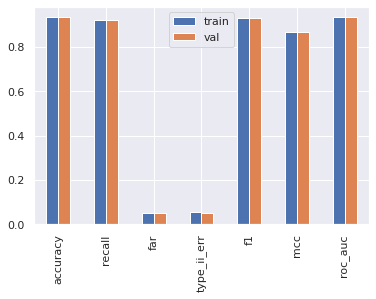

In [ ]:
hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  booster='gblinear',
  random_state=42
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = "pca"
performance["feature_sel"] = ""
performance["feature_sel"] = ""
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)
model.fit(X_train_pca, y_train) # <------------- only pca features

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train_pca)); # <------------- only pca features
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val_pca)); # <------------- only pca features

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

##  Raw fetures & PCA features generation + Linear booster XGBoost Classifier

In [ ]:
X_train_extended_pca = pd.concat([X_train.reset_index(), X_train_pca], axis=1).drop(columns=['index'])
X_val_extended_pca = pd.concat([X_val.reset_index(), X_val_pca], axis=1).drop(columns=['index'])

print('Train Set shape')
print(X_train_extended_pca.shape)
print('Validation Set shape')
print(X_val_extended_pca.shape)


Train Set shape
(77635, 162)
Validation Set shape
(19409, 162)



Train Dataset

Confussion Matrix:
	35798	3019
	2192	36626
Accuracy: 0.9328782121465834
Detection Rate: 0.9222247984130665
False Alarm Rate: 0.055290705006936565
Type II Error: 0.056468648565098666
F1: 0.9321546213235773
MCC: 0.865952935923818
Roc auc: 0.9328780749239839

Val Dataset

Confussion Matrix:
	8940	765
	523	9181
Accuracy: 0.9336390334380957
Detection Rate: 0.9211746522411128
False Alarm Rate: 0.05258395334807963
Type II Error: 0.05389530090684254
F1: 0.9328046744574291
MCC: 0.8675480199026381
Roc auc: 0.9336396756671351

SUMMARY
            classifier  feature_gen  ...     train       val
accuracy       xgboost  raw_and_pca  ...  0.932878  0.933639
recall         xgboost  raw_and_pca  ...  0.922225  0.921175
far            xgboost  raw_and_pca  ...  0.055291  0.052584
type_ii_err    xgboost  raw_and_pca  ...  0.056469  0.053895
f1             xgboost  raw_and_pca  ...  0.932155  0.932805
mcc            xgboost  raw_and_pca  ...  0.865953  0.867548
roc_auc        xgboost  raw

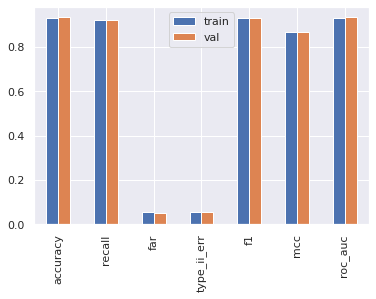

In [ ]:
hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  booster='gblinear',
  random_state=42
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = "raw_and_pca"
performance["feature_sel"] = ""
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)
model.fit(X_train_extended_pca, y_train) # <------------- raw + pca features

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train_extended_pca)); # <------------- raw + pca features
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val_extended_pca)); # <------------- raw + pca features

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

## Raw features & PCA generated features + SVM filter selection + Linear booster XGBoost Classifier

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel="linear", random_state=42)

svc.fit(X_train_extended_pca, y_train)

feature_importance = svc.coef_

In [ ]:
sorted(feature_importance[0].tolist())

[-12.700865427611173,
 -4.929327500660478,
 -4.929327500660478,
 -3.579911213680127,
 -3.319506973385529,
 -3.159516688674684,
 -2.9362706099194753,
 -2.829286991733605,
 -2.7474400794962466,
 -2.7258918604171694,
 -2.5070059503566284,
 -2.3783949611529067,
 -1.8847837506676899,
 -1.7879021762614562,
 -1.781686475430888,
 -1.6564282813629039,
 -1.571024559284826,
 -1.4868776274542155,
 -1.4868776274542155,
 -1.33332,
 -1.3236060751854692,
 -1.2794669541725507,
 -1.257725851291975,
 -1.1666137253335236,
 -1.1660079169889817,
 -1.092026345599729,
 -0.8605637233876865,
 -0.5951693676348642,
 -0.5836972808264582,
 -0.5204434264525711,
 -0.5100459521309635,
 -0.45952390707955715,
 -0.400106,
 -0.2466440470935254,
 -0.10161845554002458,
 -0.09053987690830623,
 -0.02027999439497208,
 -0.013584733891582327,
 -0.007503206560518727,
 -0.004577996143249994,
 -1.8036245977537558e-05,
 -9.22241703705804e-06,
 -8.988938124727455e-06,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


### Removal of zero importance features

All features: 162
Number of selected features: 76
Removed features: 86 (53.09%)
Selected features:
['5', '6', '8', '9', '14', '15', '16', '17', '18', '20', '26', '29', '38', '43', '47', '48', '50', '51', '52', '61', '62', '64', '66', '67', '68', '70', '71', '72', '73', '75', '76', '77', '78', '79', '80', '82', '89', '90', '93', '94', '98', '104', '106', '107', '108', '109', '111', '112', '118', '119', '120', '121', '122', '123', '126', '127', '128', '129', '130', '138', '139', '140', '141', '142', '143', '154', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9']

Train Dataset

Confussion Matrix:
	35798	3019
	2192	36626
Accuracy: 0.9328782121465834
Detection Rate: 0.9222247984130665
False Alarm Rate: 0.055290705006936565
Type II Error: 0.056468648565098666
F1: 0.9321546213235773
MCC: 0.865952935923818
Roc auc: 0.9328780749239839

Val Dataset

Confussion Matrix:
	8940	765
	523	9181
Accuracy: 0.9336390334380957
Detection Rate: 0.9211746522411128
Fals

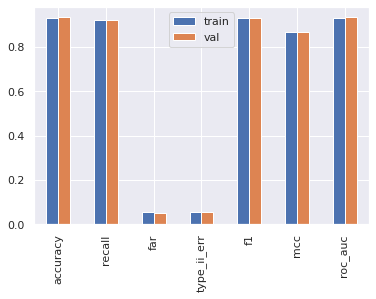

In [ ]:
selected_features = []

for feature, importance in zip(X_train_extended_pca.columns.tolist(), feature_importance.tolist()[0]):
  if abs(importance) > 0.0: # <------------- No importance features are removed
    selected_features.append(feature)

print(f'All features: {len(X_train_extended_pca.columns)}')
print(f'Number of selected features: {len(selected_features)}')
print(f'Removed features: {len(X_train_extended_pca.columns) - len(selected_features)} ({round((len(X_train_extended_pca.columns) - len(selected_features)) * 100 / len(X_train_extended_pca.columns), 2)}%)')
print('Selected features:')
print(selected_features)


X_train_selected = X_train_extended_pca[selected_features]
X_val_selected = X_val_extended_pca[selected_features]

hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  booster='gblinear',
  random_state=42
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = "raw_and_pca"
performance["feature_sel"] = "svm_coefficents_no_importance_features_removed"
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)
model.fit(X_train_selected, y_train) # <------------- selected features

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train_selected)); # <------------- selected features
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val_selected)); # <------------- selected features

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

### TOP 10 SVM features

Feature importance
107: 12.700865427611173
9: 4.929327500660478
8: 4.929327500660478
112: 4.622864193174216
pca_0: 3.579911213680127
pca_3: 3.319506973385529
pca_9: 3.159516688674684
111: 3.0629603357083726
pca_4: 2.9362706099194753
94: 2.829286991733605

All features: 162
Number of selected features: 10
Removed features: 152 (93.83%)
Selected features:
['107', '9', '8', '112', 'pca_0', 'pca_3', 'pca_9', '111', 'pca_4', '94']

Train Dataset

Confussion Matrix:
	38816	1
	21327	17491
Accuracy: 0.7252785470470793
Detection Rate: 0.9999742380915578
False Alarm Rate: 1.2192430825520237
Type II Error: 0.5494100674944613
F1: 0.7844785772029104
MCC: 0.5392273809570389
Roc auc: 0.7252820852985483

Val Dataset

Confussion Matrix:
	9703	2
	5268	4436
Accuracy: 0.7284764799835128
Detection Rate: 0.9997939206594539
False Alarm Rate: 1.1870211807120326
Type II Error: 0.542868920032976
F1: 0.7864321608040201
MCC: 0.5440001641781081
Roc auc: 0.728462500313239

SUMMARY
            classifier  feature_ge

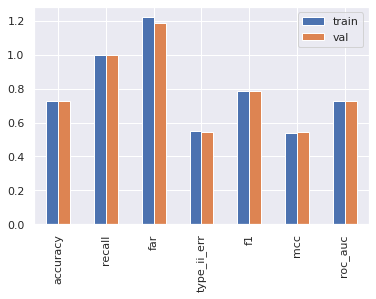

In [ ]:
res = zip(*sorted(zip([abs(x) for x in feature_importance[0].tolist()], X_train_extended_pca.columns.tolist()), reverse=True))

sorted_importance, sorted_features = res

TOP_10 = 10
selected_features = list(sorted_features[:TOP_10])
selected_importance = sorted_importance[:TOP_10]

print("Feature importance")
for feature, val in zip(selected_features, selected_importance):
  print(f"{feature}: {val}")

print(f'\nAll features: {len(X_train_extended_pca.columns)}')
print(f'Number of selected features: {len(selected_features)}')
print(f'Removed features: {len(X_train_extended_pca.columns) - len(selected_features)} ({round((len(X_train_extended_pca.columns) - len(selected_features)) * 100 / len(X_train_extended_pca.columns), 2)}%)')
print('Selected features:')
print(selected_features)


X_train_selected = X_train_extended_pca[selected_features]
X_val_selected = X_val_extended_pca[selected_features]

hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  booster='gblinear',
  random_state=42
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = "raw_and_pca"
performance["feature_sel"] = "svm_top_10_features"
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)
model.fit(X_train_selected, y_train) # <------------- selected features

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train_selected)); # <------------- selected features
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val_selected)); # <------------- selected features

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

### TOP 50 SVM features

In [ ]:
res = zip(*sorted(zip([abs(x) for x in feature_importance[0].tolist()], X_train_extended_pca.columns.tolist()), reverse=True))

sorted_importance, sorted_features = res

TOP_50 = 50
selected_features = list(sorted_features[:TOP_50])
selected_importance = sorted_importance[:TOP_50]

print("Feature importance")
for feature, val in zip(selected_features, selected_importance):
  print(f"{feature}: {val}")

print(f'\nAll features: {len(X_train_extended_pca.columns)}')
print(f'Number of selected features: {len(selected_features)}')
print(f'Removed features: {len(X_train_extended_pca.columns) - len(selected_features)} ({round((len(X_train_extended_pca.columns) - len(selected_features)) * 100 / len(X_train_extended_pca.columns), 2)}%)')
print('Selected features:')
print(selected_features)

Feature importance
107: 12.700865427611173
9: 4.929327500660478
8: 4.929327500660478
112: 4.622864193174216
pca_0: 3.579911213680127
pca_3: 3.319506973385529
pca_9: 3.159516688674684
111: 3.0629603357083726
pca_4: 2.9362706099194753
94: 2.829286991733605
77: 2.812475909561448
78: 2.7474400794962466
79: 2.7258918604171694
pca_1: 2.5070059503566284
82: 2.3783949611529067
140: 2.320677563928901
120: 2.253137933892971
73: 1.9766072637362129
98: 1.9496308060811316
90: 1.9496308060811316
70: 1.8847837506676899
122: 1.7879021762614562
93: 1.781686475430888
123: 1.6564282813629039
72: 1.571024559284826
6: 1.4868776274542155
5: 1.4868776274542155
141: 1.33332
pca_6: 1.3236060751854692
61: 1.2794669541725507
71: 1.2770116615574607
pca_2: 1.257725851291975
pca_7: 1.224592606499292
47: 1.1666137253335236
104: 1.1660079169889817
142: 1.092026345599729
109: 0.8605637233876865
75: 0.8345865930009597
pca_8: 0.7315165635787734
67: 0.5951693676348642
130: 0.5836972808264582
pca_5: 0.5222143410828624
121


Train Dataset

Confussion Matrix:
	35798	3019
	2163	36655
Accuracy: 0.9332517550074064
Detection Rate: 0.9222247984130665
False Alarm Rate: 0.05451933256036699
Type II Error: 0.055721572466381576
F1: 0.932506707650629
MCC: 0.8667142336282504
Roc auc: 0.9332516129733425

Val Dataset

Confussion Matrix:
	8940	765
	523	9181
Accuracy: 0.9336390334380957
Detection Rate: 0.9211746522411128
False Alarm Rate: 0.05258395334807963
Type II Error: 0.05389530090684254
F1: 0.9328046744574291
MCC: 0.8675480199026381
Roc auc: 0.9336396756671351

SUMMARY
            classifier  feature_gen  ...     train       val
accuracy       xgboost  raw_and_pca  ...  0.933252  0.933639
recall         xgboost  raw_and_pca  ...  0.922225  0.921175
far            xgboost  raw_and_pca  ...  0.054519  0.052584
type_ii_err    xgboost  raw_and_pca  ...  0.055722  0.053895
f1             xgboost  raw_and_pca  ...  0.932507  0.932805
mcc            xgboost  raw_and_pca  ...  0.866714  0.867548
roc_auc        xgboost  raw_

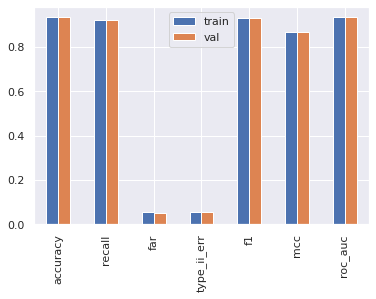

In [ ]:
X_train_selected = X_train_extended_pca[selected_features]
X_val_selected = X_val_extended_pca[selected_features]

hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  booster='gblinear',
  random_state=42 
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = "raw_and_pca"
performance["feature_sel"] = "svm_top_50_features"
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)
model.fit(X_train_selected, y_train) # <------------- selected features

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train_selected)); # <------------- selected features
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val_selected)); # <------------- selected features

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

### TOP 25 SVM features

Feature importance
107: 12.700865427611173
9: 4.929327500660478
8: 4.929327500660478
112: 4.622864193174216
pca_0: 3.579911213680127
pca_3: 3.319506973385529
pca_9: 3.159516688674684
111: 3.0629603357083726
pca_4: 2.9362706099194753
94: 2.829286991733605
77: 2.812475909561448
78: 2.7474400794962466
79: 2.7258918604171694
pca_1: 2.5070059503566284
82: 2.3783949611529067
140: 2.320677563928901
120: 2.253137933892971
73: 1.9766072637362129
98: 1.9496308060811316
90: 1.9496308060811316
70: 1.8847837506676899
122: 1.7879021762614562
93: 1.781686475430888
123: 1.6564282813629039
72: 1.571024559284826

All features: 162
Number of selected features: 25
Removed features: 137 (84.57%)
Selected features:
['107', '9', '8', '112', 'pca_0', 'pca_3', 'pca_9', '111', 'pca_4', '94', '77', '78', '79', 'pca_1', '82', '140', '120', '73', '98', '90', '70', '122', '93', '123', '72']

Train Dataset

Confussion Matrix:
	35793	3024
	2098	36720
Accuracy: 0.9340246023056611
Detection Rate: 0.9220959888708555
Fal

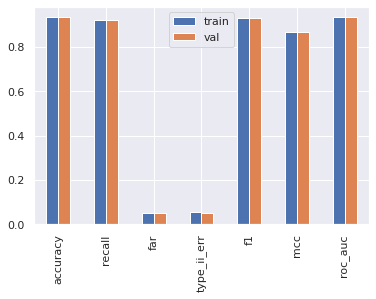

In [ ]:
res = zip(*sorted(zip([abs(x) for x in feature_importance[0].tolist()], X_train_extended_pca.columns.tolist()), reverse=True))

sorted_importance, sorted_features = res

TOP_25 = 25
selected_features = list(sorted_features[:TOP_25])
selected_importance = sorted_importance[:TOP_25]

print("Feature importance")
for feature, val in zip(selected_features, selected_importance):
  print(f"{feature}: {val}")

print(f'\nAll features: {len(X_train_extended_pca.columns)}')
print(f'Number of selected features: {len(selected_features)}')
print(f'Removed features: {len(X_train_extended_pca.columns) - len(selected_features)} ({round((len(X_train_extended_pca.columns) - len(selected_features)) * 100 / len(X_train_extended_pca.columns), 2)}%)')
print('Selected features:')
print(selected_features)


X_train_selected = X_train_extended_pca[selected_features]
X_val_selected = X_val_extended_pca[selected_features]

hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  booster='gblinear',
  random_state=42 
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = "raw_and_pca"
performance["feature_sel"] = "svm_top_25_features"
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)
model.fit(X_train_selected, y_train) # <------------- selected features

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train_selected)); # <------------- selected features
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val_selected)); # <------------- selected features

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

### TOP 15 SVM features

Feature importance
107: 12.700865427611173
9: 4.929327500660478
8: 4.929327500660478
112: 4.622864193174216
pca_0: 3.579911213680127
pca_3: 3.319506973385529
pca_9: 3.159516688674684
111: 3.0629603357083726
pca_4: 2.9362706099194753
94: 2.829286991733605
77: 2.812475909561448
78: 2.7474400794962466
79: 2.7258918604171694
pca_1: 2.5070059503566284
82: 2.3783949611529067

All features: 162
Number of selected features: 15
Removed features: 147 (90.74%)
Selected features:
['107', '9', '8', '112', 'pca_0', 'pca_3', 'pca_9', '111', 'pca_4', '94', '77', '78', '79', 'pca_1', '82']

Train Dataset

Confussion Matrix:
	35793	3024
	2100	36718
Accuracy: 0.9339988407290526
Detection Rate: 0.9220959888708555
False Alarm Rate: 0.05284082331035177
Type II Error: 0.054098614045030656
F1: 0.9332029722330856
MCC: 0.8682436563332583
Roc auc: 0.9339986874129125

Val Dataset

Confussion Matrix:
	8937	768
	499	9205
Accuracy: 0.9347210057189963
Detection Rate: 0.9208655332302936
False Alarm Rate: 0.05003509475

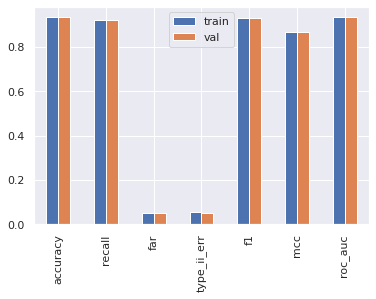

In [ ]:
res = zip(*sorted(zip([abs(x) for x in feature_importance[0].tolist()], X_train_extended_pca.columns.tolist()), reverse=True))

sorted_importance, sorted_features = res

TOP_15 = 15
selected_features = list(sorted_features[:TOP_15])
selected_importance = sorted_importance[:TOP_15]

print("Feature importance")
for feature, val in zip(selected_features, selected_importance):
  print(f"{feature}: {val}")

print(f'\nAll features: {len(X_train_extended_pca.columns)}')
print(f'Number of selected features: {len(selected_features)}')
print(f'Removed features: {len(X_train_extended_pca.columns) - len(selected_features)} ({round((len(X_train_extended_pca.columns) - len(selected_features)) * 100 / len(X_train_extended_pca.columns), 2)}%)')
print('Selected features:')
print(selected_features)


X_train_selected = X_train_extended_pca[selected_features]
X_val_selected = X_val_extended_pca[selected_features]

hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  booster='gblinear',
  random_state=42
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = "raw_and_pca"
performance["feature_sel"] = "svm_top_15_features"
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)
model.fit(X_train_selected, y_train) # <------------- selected features

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train_selected)); # <------------- selected features
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val_selected)); # <------------- selected features

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

### RAW + PCA - SVM weigthed features selection comparisson

In [ ]:
final_res = pd.concat(overall_results)
final_res.loc['f1'].sort_values(by="val", ascending=False)

,classifier,feature_gen,feature_sel,hyperparams,train,val
f1,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'random_st...",0.998687,0.998405
f1,xgboost,raw_and_pca,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933203,0.933807
f1,xgboost,pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933187,0.933779
f1,xgboost,raw_and_pca,svm_top_25_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933227,0.933563
f1,xgboost,raw_and_pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.932155,0.932805
f1,xgboost,raw_and_pca,svm_coefficents_no_importance_features_removed,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.932155,0.932805
f1,xgboost,raw_and_pca,svm_top_50_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.932507,0.932805
f1,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.928076,0.929063
f1,xgboost,raw_and_pca,svm_top_10_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.784479,0.786432


In [ ]:
final_res.loc['mcc'].sort_values(by="val", ascending=False)

,classifier,feature_gen,feature_sel,hyperparams,train,val
mcc,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'random_st...",0.997374,0.996809
mcc,xgboost,raw_and_pca,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.868244,0.869776
mcc,xgboost,pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.868186,0.869656
mcc,xgboost,raw_and_pca,svm_top_25_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.868296,0.869249
mcc,xgboost,raw_and_pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.865953,0.867548
mcc,xgboost,raw_and_pca,svm_coefficents_no_importance_features_removed,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.865953,0.867548
mcc,xgboost,raw_and_pca,svm_top_50_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.866714,0.867548
mcc,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.856546,0.858757
mcc,xgboost,raw_and_pca,svm_top_10_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.539227,0.544000


In [ ]:
final_res.loc['roc_auc'].sort_values(by="val", ascending=False)

,classifier,feature_gen,feature_sel,hyperparams,train,val
roc_auc,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'random_st...",0.998686,0.998403
roc_auc,xgboost,raw_and_pca,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933999,0.934722
roc_auc,xgboost,pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933973,0.934670
roc_auc,xgboost,raw_and_pca,svm_top_25_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.934024,0.934464
roc_auc,xgboost,raw_and_pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.932878,0.933640
roc_auc,xgboost,raw_and_pca,svm_coefficents_no_importance_features_removed,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.932878,0.933640
roc_auc,xgboost,raw_and_pca,svm_top_50_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933252,0.933640
roc_auc,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.928267,0.929363
roc_auc,xgboost,raw_and_pca,svm_top_10_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.725282,0.728463


In [ ]:
final_res.loc['far'].sort_values(by="val", ascending=True)

,classifier,feature_gen,feature_sel,hyperparams,train,val
far,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'random_st...",0.002245,0.002893
far,xgboost,raw_and_pca,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.052841,0.050035
far,xgboost,pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.053033,0.050472
far,xgboost,raw_and_pca,svm_top_25_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.052788,0.050562
far,xgboost,raw_and_pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.055291,0.052584
far,xgboost,raw_and_pca,svm_coefficents_no_importance_features_removed,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.055291,0.052584
far,xgboost,raw_and_pca,svm_top_50_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.054519,0.052584
far,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.068729,0.065802
far,xgboost,raw_and_pca,svm_top_10_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",1.219243,1.187021


## Auto Encoder feature generation + XGBoost classifier


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 5)                 765       
                                                                 
 sequential_10 (Sequential)  (None, 152)               912       
                                                                 
Total params: 1,677
Trainable params: 1,677
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2427/2427 [==============================] - 5s 2ms/step - loss: 0.0083 - val_loss: 0.0026
Epoch 2/10
2427/2427 [==============================] - 4s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 3/10
2427/2427 [==============================] - 5s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/10
2427/2427 [==============================] - 4s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/10
2427/2427 [============

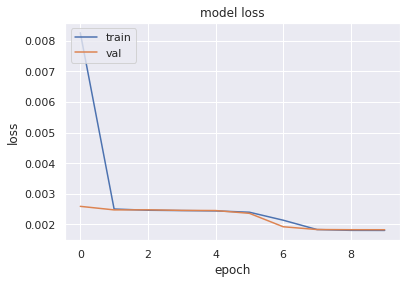

In [ ]:
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)
np.random.seed(42)

n = 5
_, input_neurons = X_train.shape

encoder = keras.models.Sequential([
    keras.layers.Dense(n, input_shape=[input_neurons]),
])
decoder = keras.models.Sequential([
    keras.layers.Dense(input_neurons, input_shape=[n]),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

print(autoencoder.summary())

history = autoencoder.fit(
    X_train, X_train, epochs=10,
    validation_data=(X_val, X_val)
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(
    'autoencoder_train_loss.jpg',
    bbox_inches='tight',
)
plt.show()

In [ ]:
ae_train_feature_array = np.array(encoder.predict(X_train))
ae_val_feature_array = np.array(encoder.predict(X_val))

ae_train_features = create_new_features_dataframe(ae_train_feature_array , "ae")
ae_val_features = create_new_features_dataframe(ae_val_feature_array , "ae")

ae_train_features

,ae_0,ae_1,ae_2,ae_3,ae_4
0,0.258622,0.670984,1.008826,0.746815,0.270130
1,0.525508,0.990891,0.644825,-0.334003,-1.601542
2,0.512356,1.154855,-0.019052,0.477123,-0.113239
3,0.526419,0.988263,0.644182,-0.334215,-1.602047
4,1.545967,1.391539,-0.364725,0.931219,-0.258371
...,...,...,...,...,...
77630,0.880399,0.539334,-0.095902,-0.446781,-0.925001
77631,1.763041,1.320279,-0.449332,0.965185,-0.209466
77632,1.083912,0.493317,0.096118,-0.256862,-0.885092
77633,0.526412,0.988247,0.644150,-0.334243,-1.602073


### Encoded features + XGBoost Classifier


Train Dataset

Confussion Matrix:
	35804	3013
	2311	36507
Accuracy: 0.9314226830682037
Detection Rate: 0.9223793698637195
False Alarm Rate: 0.05847672064777328
Type II Error: 0.059534236694317066
F1: 0.9307960276607913
MCC: 0.8629864672402159
Roc auc: 0.9314225665847012

Val Dataset

Confussion Matrix:
	8943	762
	550	9154
Accuracy: 0.932402493688495
Detection Rate: 0.921483771251932
False Alarm Rate: 0.055465913674868896
Type II Error: 0.05667765869744435
F1: 0.9316595478695698
MCC: 0.8650115669736258
Roc auc: 0.9324030562772438

SUMMARY
            classifier  feature_gen  ...     train       val
accuracy       xgboost  autoencoder  ...  0.931423  0.932402
recall         xgboost  autoencoder  ...  0.922379  0.921484
far            xgboost  autoencoder  ...  0.058477  0.055466
type_ii_err    xgboost  autoencoder  ...  0.059534  0.056678
f1             xgboost  autoencoder  ...  0.930796  0.931660
mcc            xgboost  autoencoder  ...  0.862986  0.865012
roc_auc        xgboost  auto

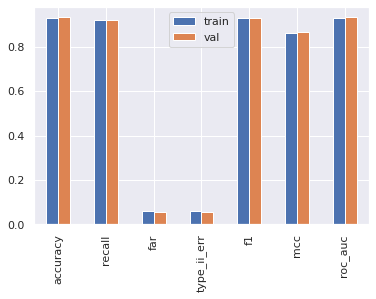

In [ ]:
hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  booster='gblinear',
  random_state=42
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = "autoencoder"
performance["feature_sel"] = ""
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)
model.fit(ae_train_features, y_train) # <------------- ae features

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(ae_train_features)); # <------------- ae features
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(ae_val_features)); # <------------- ae features

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

### Raw & Encoded features + SVM filter selection (top 15) + XGBoost classifer

In [ ]:
X_train_extended_ae = pd.concat([X_train.reset_index(), ae_train_features], axis=1).drop(columns=['index'])
X_val_extended_ae = pd.concat([X_val.reset_index(), ae_val_features], axis=1).drop(columns=['index'])

print('Train Set shape')
print(X_train_extended_ae.shape)
print('Validation Set shape')
print(X_val_extended_ae.shape)


svc = SVC(kernel="linear", random_state=42)

svc.fit(X_train_extended_ae, y_train)

feature_importance = svc.coef_

Train Set shape
(77635, 157)
Validation Set shape
(19409, 157)


Feature importance
107: 12.989094916824241
9: 5.238372754728378
8: 5.238372754728378
112: 4.5861180033180045
ae_0: 4.556829886013979
94: 3.809635219611174
82: 3.1303600570917034
77: 3.1143230818550847
111: 2.963245287278358
120: 2.758076944391067
78: 2.7439074419759684
79: 2.7259599867219317
ae_3: 2.6548797038762793
140: 2.5844740137810236
130: 2.390954314983603

All features: 157
Number of selected features: 15
Removed features: 142 (90.45%)
Selected features:
['107', '9', '8', '112', 'ae_0', '94', '82', '77', '111', '120', '78', '79', 'ae_3', '140', '130']

Train Dataset

Confussion Matrix:
	35788	3029
	437	38381
Accuracy: 0.9553551877374895
Detection Rate: 0.9219671793286447
False Alarm Rate: 0.010553006520164212
Type II Error: 0.011257663970323045
F1: 0.9538125316489432
MCC: 0.9127474400064057
Roc auc: 0.9553547576791609

Val Dataset

Confussion Matrix:
	8935	770
	101	9603
Accuracy: 0.955123911587408
Detection Rate: 0.9206594538897476
False Alarm Rate: 0.00973681673575629
Type II E

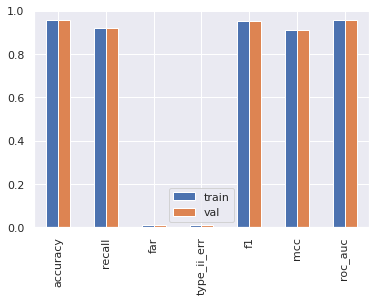

In [ ]:
res = zip(*sorted(zip([abs(x) for x in feature_importance[0].tolist()], X_train_extended_ae.columns.tolist()), reverse=True))

sorted_importance, sorted_features = res

TOP_15 = 15
selected_features = list(sorted_features[:TOP_15])
selected_importance = sorted_importance[:TOP_15]

print("Feature importance")
for feature, val in zip(selected_features, selected_importance):
  print(f"{feature}: {val}")

print(f'\nAll features: {len(X_train_extended_ae.columns)}')
print(f'Number of selected features: {len(selected_features)}')
print(f'Removed features: {len(X_train_extended_ae.columns) - len(selected_features)} ({round((len(X_train_extended_ae.columns) - len(selected_features)) * 100 / len(X_train_extended_ae.columns), 2)}%)')
print('Selected features:')
print(selected_features)


X_train_selected = X_train_extended_ae[selected_features]
X_val_selected = X_val_extended_ae[selected_features]

hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  booster='gblinear',
  random_state=42 
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = "raw_and_ae"
performance["feature_sel"] = "svm_top_15_features"
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)
model.fit(X_train_selected, y_train) # <------------- selected features

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train_selected)); # <------------- selected features
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val_selected)); # <------------- selected features

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

### AutoEncoder feature generation + ANN classifier




Train Dataset

Confussion Matrix:
	38598	219
	769	38049
Accuracy: 0.9872737811554068
Detection Rate: 0.9943581420511631
False Alarm Rate: 0.02009511863698129
Type II Error: 0.019810397238394558
F1: 0.9873631433541389
MCC: 0.974645405171136
Roc auc: 0.9872738724063844

Val Dataset

Confussion Matrix:
	9645	60
	170	9534
Accuracy: 0.98814982739966
Detection Rate: 0.9938176197836167
False Alarm Rate: 0.017719407963310403
Type II Error: 0.017518549051937345
F1: 0.9882172131147542
MCC: 0.9763623650094356
Roc auc: 0.9881495353658397

SUMMARY
            classifier  feature_gen  ...     train       val
accuracy           ann  autoencoder  ...  0.987274  0.988150
recall             ann  autoencoder  ...  0.994358  0.993818
far                ann  autoencoder  ...  0.020095  0.017719
type_ii_err        ann  autoencoder  ...  0.019810  0.017519
f1                 ann  autoencoder  ...  0.987363  0.988217
mcc                ann  autoencoder  ...  0.974645  0.976362
roc_auc            ann  autoenc

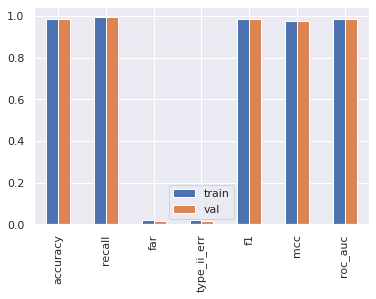

In [ ]:
from sklearn.neural_network import MLPClassifier

# MOST SIMPLE MULTILAYER PERCEPTRON
hyperparams = dict(
      hidden_layer_sizes=(
          5,
      ),
      random_state=1
)

performance = {}

performance["classifier"] = "ann"
performance["feature_gen"] = "autoencoder"
performance["feature_sel"] = ""
performance["hyperparams"] =str(hyperparams)

model = MLPClassifier(**hyperparams)
model.fit(ae_train_features, y_train)

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(ae_train_features)); # <------------- ae features
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(ae_val_features)); # <------------- ae features

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

### PCA features only + SVM classfier


Train Dataset

Confussion Matrix:
	38676	141
	548	38270
Accuracy: 0.9911251368583758
Detection Rate: 0.996367570909653
False Alarm Rate: 0.014266746504907448
Type II Error: 0.014117162141274666
F1: 0.9911713073897055
MCC: 0.9823042721063745
Roc auc: 0.9911252043841892

Val Dataset

Confussion Matrix:
	9661	44
	139	9565
Accuracy: 0.9905713844092947
Detection Rate: 0.9954662545079855
False Alarm Rate: 0.014465605161827454
Type II Error: 0.0143239901071723
F1: 0.9906177903101768
MCC: 0.9811897740739963
Roc auc: 0.9905711322004066

SUMMARY
            classifier feature_gen  ...     train       val
accuracy           svm         pca  ...  0.991125  0.990571
recall             svm         pca  ...  0.996368  0.995466
far                svm         pca  ...  0.014267  0.014466
type_ii_err        svm         pca  ...  0.014117  0.014324
f1                 svm         pca  ...  0.991171  0.990618
mcc                svm         pca  ...  0.982304  0.981190
roc_auc            svm         pca  .

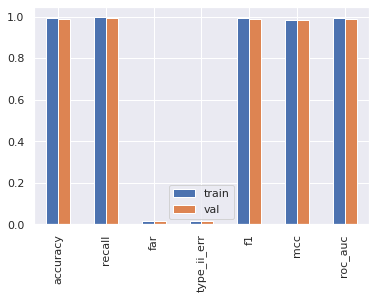

In [ ]:
from sklearn.svm import LinearSVC

model = LinearSVC() # <------------- SVM Classifier

model.fit(X_train_pca, y_train) # <------------- PCA only features

performance = {}

hyperparams = model.get_params()

performance["classifier"] = "svm"
performance["feature_gen"] = "pca"
performance["feature_sel"] = ""
performance["hyperparams"] =str(hyperparams)

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train_pca)); # <------------- PCA only features
print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val_pca)); # <------------- PCA only features

summary = pd.DataFrame(performance)
overall_results.append(summary)

print('\nSUMMARY')
print(summary)

sns.set(font_scale=1)
img = summary.plot.bar(subplots=False, grid=True)
img.figure.savefig(
    f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}.jpg',
    bbox_inches='tight',
)

# Analysis of all the tested approaches

In [ ]:
pd.concat(overall_results).loc["f1"].sort_values(by="val", ascending=False)

,classifier,feature_gen,feature_sel,hyperparams,train,val
f1,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'random_st...",0.998687,0.998405
f1,svm,pca,,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.991171,0.990618
f1,ann,autoencoder,,"{'hidden_layer_sizes': (5,), 'random_state': 1}",0.987363,0.988217
f1,xgboost,raw_and_ae,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.953813,0.953524
f1,xgboost,raw_and_pca,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933203,0.933807
f1,xgboost,pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933187,0.933779
f1,xgboost,raw_and_pca,svm_top_25_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933227,0.933563
f1,xgboost,raw_and_pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.932155,0.932805
f1,xgboost,raw_and_pca,svm_coefficents_no_importance_features_removed,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.932155,0.932805
f1,xgboost,raw_and_pca,svm_top_50_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.932507,0.932805


In [ ]:
pd.concat(overall_results).loc["mcc"].sort_values(by="val", ascending=False)

,classifier,feature_gen,feature_sel,hyperparams,train,val
mcc,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'random_st...",0.997374,0.996809
mcc,svm,pca,,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.982304,0.981190
mcc,ann,autoencoder,,"{'hidden_layer_sizes': (5,), 'random_state': 1}",0.974645,0.976362
mcc,xgboost,raw_and_ae,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.912747,0.912419
mcc,xgboost,raw_and_pca,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.868244,0.869776
mcc,xgboost,pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.868186,0.869656
mcc,xgboost,raw_and_pca,svm_top_25_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.868296,0.869249
mcc,xgboost,raw_and_pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.865953,0.867548
mcc,xgboost,raw_and_pca,svm_coefficents_no_importance_features_removed,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.865953,0.867548
mcc,xgboost,raw_and_pca,svm_top_50_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.866714,0.867548


In [ ]:
pd.concat(overall_results).loc["roc_auc"].sort_values(by="val", ascending=False)

,classifier,feature_gen,feature_sel,hyperparams,train,val
roc_auc,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'random_st...",0.998686,0.998403
roc_auc,svm,pca,,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.991125,0.990571
roc_auc,ann,autoencoder,,"{'hidden_layer_sizes': (5,), 'random_state': 1}",0.987274,0.988150
roc_auc,xgboost,raw_and_ae,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.955355,0.955126
roc_auc,xgboost,raw_and_pca,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933999,0.934722
roc_auc,xgboost,pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933973,0.934670
roc_auc,xgboost,raw_and_pca,svm_top_25_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.934024,0.934464
roc_auc,xgboost,raw_and_pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.932878,0.933640
roc_auc,xgboost,raw_and_pca,svm_coefficents_no_importance_features_removed,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.932878,0.933640
roc_auc,xgboost,raw_and_pca,svm_top_50_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.933252,0.933640


In [ ]:
pd.concat(overall_results).loc["far"].sort_values(by="val", ascending=True)

,classifier,feature_gen,feature_sel,hyperparams,train,val
far,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'random_st...",0.002245,0.002893
far,xgboost,raw_and_ae,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.010553,0.009737
far,svm,pca,,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.014267,0.014466
far,ann,autoencoder,,"{'hidden_layer_sizes': (5,), 'random_state': 1}",0.020095,0.017719
far,xgboost,raw_and_pca,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.052841,0.050035
far,xgboost,pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.053033,0.050472
far,xgboost,raw_and_pca,svm_top_25_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.052788,0.050562
far,xgboost,raw_and_pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.055291,0.052584
far,xgboost,raw_and_pca,svm_coefficents_no_importance_features_removed,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.055291,0.052584
far,xgboost,raw_and_pca,svm_top_50_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.054519,0.052584


In [ ]:
pd.concat(overall_results).loc["type_ii_err"].sort_values(by="val", ascending=True)

,classifier,feature_gen,feature_sel,hyperparams,train,val
type_ii_err,xgboost,,,"{'n_estimators': 3, 'max_depth': 3, 'random_st...",0.002241,0.002885
type_ii_err,xgboost,raw_and_ae,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.011258,0.010408
type_ii_err,svm,pca,,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.014117,0.014324
type_ii_err,ann,autoencoder,,"{'hidden_layer_sizes': (5,), 'random_state': 1}",0.019810,0.017519
type_ii_err,xgboost,raw_and_pca,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.054099,0.051422
type_ii_err,xgboost,pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.054279,0.051834
type_ii_err,xgboost,raw_and_pca,svm_top_25_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.054047,0.051937
type_ii_err,xgboost,raw_and_pca,,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.056469,0.053895
type_ii_err,xgboost,raw_and_pca,svm_coefficents_no_importance_features_removed,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.056469,0.053895
type_ii_err,xgboost,raw_and_pca,svm_top_50_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.055722,0.053895


# Time to Build & Time to Test metrics

## XGBoost Classifier + Raw & AE generated features + SVM selection method (top 15)

In [ ]:
TTB = 0
TTM = 0

build_time = {"step": "build"}
test_time = {"step": "test"}

time_over_all_results = []
selected_candidates_overall_results = []

# AUTOENCODER FEATURE GENERATION

n = 5
_, input_neurons = X_train.shape

encoder = keras.models.Sequential([
    keras.layers.Dense(n, input_shape=[input_neurons]),
])
decoder = keras.models.Sequential([
    keras.layers.Dense(input_neurons, input_shape=[n]),
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

print(autoencoder.summary())

t0 = time()

history = autoencoder.fit(
    X_train, X_train, epochs=10,
    validation_data=(X_val, X_val)
)

feature_generator_build_time = time() - t0
TTB += feature_generator_build_time
build_time["feature_generation"] = round(feature_generator_build_time, 2)

t0 = time()

ae_train_feature_array = np.array(encoder.predict(X_train))

feature_generator_test_time = time() - t0
TTM += feature_generator_test_time
test_time["feature_generation"] = round(feature_generator_test_time, 2)

ae_val_feature_array = np.array(encoder.predict(X_val))
ae_test_feature_array = np.array(encoder.predict(X_test))


ae_train_features = create_new_features_dataframe(ae_train_feature_array , "ae")
ae_val_features = create_new_features_dataframe(ae_val_feature_array , "ae")
ae_test_features = create_new_features_dataframe(ae_test_feature_array , "ae")

X_train_extended_ae = pd.concat([X_train.reset_index(), ae_train_features], axis=1).drop(columns=['index'])
X_val_extended_ae = pd.concat([X_val.reset_index(), ae_val_features], axis=1).drop(columns=['index'])
X_test_extended_ae = pd.concat([X_test.reset_index(), ae_test_features], axis=1).drop(columns=['index'])

# SVM FEATURE SELECTION

svc = SVC(kernel="linear", random_state=42)

t0 = time()

svc.fit(X_train_extended_ae, y_train)

feature_selector_build_time = time() - t0
TTB += feature_selector_build_time
build_time["feature_selection"] = round(feature_selector_build_time, 2)

feature_importance = svc.coef_

res = zip(*sorted(zip([abs(x) for x in feature_importance[0].tolist()], X_train_extended_ae.columns.tolist()), reverse=True))

sorted_importance, sorted_features = res

TOP_15 = 15
selected_features = list(sorted_features[:TOP_15])
selected_importance = sorted_importance[:TOP_15]

X_train_selected = X_train_extended_ae[selected_features]
X_val_selected = X_val_extended_ae[selected_features]
X_test_selected = X_test_extended_ae[selected_features]


# XGBOOST CLASSIFICATION

hyperparams = dict(
  n_estimators=3,
  max_depth=3,
  booster='gblinear',
  random_state=42
)

performance = {}

performance["classifier"] = "xgboost"
performance["feature_gen"] = "raw_and_ae"
performance["feature_sel"] = "svm_top_15_features"
performance["hyperparams"] =str(hyperparams)

model = xgb.XGBClassifier(**hyperparams)

t0 = time()

model.fit(X_train_selected, y_train)

classifier_build_time = time() - t0
TTB += classifier_build_time
build_time["classification"] = round(classifier_build_time, 2)

t0 = time()

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train_selected))

classifier_test_time = time() - t0
TTM += classifier_test_time
test_time["classification"] = round(classifier_test_time, 2)

print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val_selected))

print('\nTest Dataset\n')
performance['test'] = evaluate_results(y_test, model.predict(X_test_selected))

summary = pd.DataFrame(performance)
selected_candidates_overall_results.append(summary)

print('\nSUMMARY')
print(summary)

build_time["experiment"] = f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}'
test_time["experiment"] = f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}'

time_summary = []
time_summary.append(build_time)
time_summary.append(test_time)

print(f"TOTAL TTB: {TTB}")
print(f"TOTAL TTM: {TTM}")

time_over_all_results.append(pd.DataFrame(time_summary))
pd.DataFrame(time_summary)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 5)                 765       
                                                                 
 sequential_13 (Sequential)  (None, 152)               912       
                                                                 
Total params: 1,677
Trainable params: 1,677
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2427/2427 [==============================] - 5s 2ms/step - loss: 0.0080 - val_loss: 0.0025
Epoch 2/10
2427/2427 [==============================] - 4s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 3/10
2427/2427 [==============================] - 4s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/10
2427/2427 [==============================] - 4s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/10
2427/2427 [============

,step,feature_generation,feature_selection,classification,experiment
0,build,41.04,47.12,0.16,xgboost_raw_and_ae_svm_top_15_features
1,test,1.93,NaN,0.15,xgboost_raw_and_ae_svm_top_15_features


## SVM Classifier + PCA features + No selection method

In [ ]:
TTB = 0
TTM = 0

build_time = {"step": "build"}
test_time = {"step": "test"}


# PCA FEATURE GENERATION

pca = PCA(n_components=10, random_state=1)

t0 = time()

model = pca.fit(X_train)

feature_generator_build_time = time() - t0
TTB += feature_generator_build_time
build_time["feature_generation"] = round(feature_generator_build_time, 2)

t0 = time()

X_train_pca = model.transform(X_train)

feature_generator_test_time = time() - t0
TTM += feature_generator_test_time
test_time["feature_generation"] = round(feature_generator_test_time, 2)

X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

X_train_pca = create_new_features_dataframe(X_train_pca, 'pca')
X_val_pca = create_new_features_dataframe(X_val_pca, 'pca')
X_test_pca = create_new_features_dataframe(X_test_pca, 'pca')


# NO FEATURE SELECTION



# SVM CLASSIFICATION

model = SVC(kernel="linear", random_state=42) # <------------- SVM Classifier

hyperparams = model.get_params()

performance = {}

performance["classifier"] = "svm"
performance["feature_gen"] = "pca"
performance["feature_sel"] = ""
performance["hyperparams"] =str(hyperparams)


t0 = time()

model.fit(X_train_pca, y_train) # <------------- PCA only features

classifier_build_time = time() - t0
TTB += classifier_build_time
build_time["classification"] = round(classifier_build_time, 2)

t0 = time()

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(X_train_pca))

classifier_test_time = time() - t0
TTM += classifier_test_time
test_time["classification"] = round(classifier_test_time, 2)

print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(X_val_pca))

print('\nTest Dataset\n')
performance['test'] = evaluate_results(y_test, model.predict(X_test_pca))

summary = pd.DataFrame(performance)
selected_candidates_overall_results.append(summary)

print('\nSUMMARY')
print(summary)

build_time["experiment"] = f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}'
test_time["experiment"] = f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}'

time_summary = []
time_summary.append(build_time)
time_summary.append(test_time)

print(f"TOTAL TTB: {TTB}")
print(f"TOTAL TTM: {TTM}")

time_over_all_results.append(pd.DataFrame(time_summary))
pd.DataFrame(time_summary)


Train Dataset

Confussion Matrix:
	38611	206
	504	38314
Accuracy: 0.9908546403039866
Detection Rate: 0.9946930468609114
False Alarm Rate: 0.013084112149532711
Type II Error: 0.012983667370807358
F1: 0.9908894934045064
MCC: 0.9817382124791819
Roc auc: 0.9908546897450521

Val Dataset

Confussion Matrix:
	9646	59
	129	9575
Accuracy: 0.9903137719614612
Detection Rate: 0.9939206594538897
False Alarm Rate: 0.013390076811293335
Type II Error: 0.013293487221764221
F1: 0.9903490759753594
MCC: 0.980653048472574
Roc auc: 0.9903135861160628

Test Dataset

Confussion Matrix:
	5866	14213
	475	19604
Accuracy: 0.6342447333034513
Detection Rate: 0.2921460232083271
False Alarm Rate: 0.014046189786202206
Type II Error: 0.023656556601424374
F1: 0.4440575321725965
MCC: 0.36814839927410176
Roc auc: 0.6342447333034513

SUMMARY
            classifier feature_gen feature_sel  ...     train       val      test
accuracy           svm         pca              ...  0.990855  0.990314  0.634245
recall             

,step,feature_generation,classification,experiment
0,build,1.18,8.59,svm_pca_
1,test,0.07,3.32,svm_pca_


## ANN Classifier + AE features + No selection method

In [ ]:
TTB = 0
TTM = 0

build_time = {"step": "build"}
test_time = {"step": "test"}


# AUTOENCODER FEATURE GENERATION

n = 5
_, input_neurons = X_train.shape

encoder = keras.models.Sequential([
    keras.layers.Dense(n, input_shape=[input_neurons]),
])
decoder = keras.models.Sequential([
    keras.layers.Dense(input_neurons, input_shape=[n]),
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

print(autoencoder.summary())

t0 = time()

history = autoencoder.fit(
    X_train, X_train, epochs=10,
    validation_data=(X_val, X_val)
)

feature_generator_build_time = time() - t0
TTB += feature_generator_build_time
build_time["feature_generation"] = round(feature_generator_build_time, 2)

t0 = time()

ae_train_feature_array = np.array(encoder.predict(X_train))

feature_generator_test_time = time() - t0
TTM += feature_generator_test_time
test_time["feature_generation"] = round(feature_generator_test_time, 2)

ae_val_feature_array = np.array(encoder.predict(X_val))
ae_test_feature_array = np.array(encoder.predict(X_test))


ae_train_features = create_new_features_dataframe(ae_train_feature_array , "ae")
ae_val_features = create_new_features_dataframe(ae_val_feature_array , "ae")
ae_test_features = create_new_features_dataframe(ae_test_feature_array , "ae")


# NO FEATURE SELECTION


# ANN CLASSIFICATION

hyperparams = dict(
      hidden_layer_sizes=(
          5,
      ),
      random_state=1
)

performance = {}

performance["classifier"] = "ann"
performance["feature_gen"] = "autoencoder"
performance["feature_sel"] = ""
performance["hyperparams"] =str(hyperparams)

model = MLPClassifier(**hyperparams)
model.fit(ae_train_features, y_train)

t0 = time()

model.fit(ae_train_features, y_train)

classifier_build_time = time() - t0
TTB += classifier_build_time
build_time["classification"] = round(classifier_build_time, 2)

t0 = time()

print('\nTrain Dataset\n')
performance['train'] = evaluate_results(y_train, model.predict(ae_train_features))

classifier_test_time = time() - t0
TTM += classifier_test_time
test_time["classification"] = round(classifier_test_time, 2)

print('\nVal Dataset\n')
performance['val'] = evaluate_results(y_val, model.predict(ae_val_features))

print('\nTest Dataset\n')
performance['test'] = evaluate_results(y_test, model.predict(ae_test_features))

summary = pd.DataFrame(performance)
selected_candidates_overall_results.append(summary)

print('\nSUMMARY')
print(summary)

build_time["experiment"] = f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}'
test_time["experiment"] = f'{performance["classifier"]}_{performance["feature_gen"]}_{performance["feature_sel"]}'

time_summary = []
time_summary.append(build_time)
time_summary.append(test_time)

print(f"TOTAL TTB: {TTB}")
print(f"TOTAL TTM: {TTM}")

time_over_all_results.append(pd.DataFrame(time_summary))
pd.DataFrame(time_summary)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 5)                 765       
                                                                 
 sequential_16 (Sequential)  (None, 152)               912       
                                                                 
Total params: 1,677
Trainable params: 1,677
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2427/2427 [==============================] - 4s 2ms/step - loss: 0.0080 - val_loss: 0.0025
Epoch 2/10
2427/2427 [==============================] - 4s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 3/10
2427/2427 [==============================] - 4s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/10
2427/2427 [==============================] - 4s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/10
2427/2427 [============

,step,feature_generation,classification,experiment
0,build,41.59,20.09,ann_autoencoder_
1,test,2.74,0.15,ann_autoencoder_


## TTB & TTM metrics comparisson

In [ ]:
numerics = ['float64']
time_over_all_results_df = pd.concat(time_over_all_results)
time_over_all_results_df["total"] = time_over_all_results_df.select_dtypes(include=numerics).sum(axis=1)
time_over_all_results_df

,step,feature_generation,feature_selection,classification,experiment,total
0,build,41.04,47.12,0.16,xgboost_raw_and_ae_svm_top_15_features,88.32
1,test,1.93,NaN,0.15,xgboost_raw_and_ae_svm_top_15_features,2.08
0,build,1.18,NaN,8.59,svm_pca_,9.77
1,test,0.07,NaN,3.32,svm_pca_,3.39
0,build,41.59,NaN,20.09,ann_autoencoder_,61.68
1,test,2.74,NaN,0.15,ann_autoencoder_,2.89


In [ ]:
time_over_all_results_df.groupby(["experiment"]).sum().sort_values(by="total", ascending=True)

,feature_generation,feature_selection,classification,total
experiment,,,,
svm_pca_,1.25,0.00,11.91,13.16
ann_autoencoder_,44.33,0.00,20.24,64.57
xgboost_raw_and_ae_svm_top_15_features,42.97,47.12,0.31,90.40


We can observe that the introduction of neural networks as feature generation algorithms increase drastically TTB, this was expected as the process of training NNs is computationally expensive compared to other techniques. We can also observe that including feature selection phase also impacts building times but now always is translated into performance improvements.

# 3 chosen algorithms evaluation checks

In [ ]:
final_results = pd.concat(selected_candidates_overall_results)
final_results.loc["f1"].sort_values(by="test", ascending=False)

,classifier,feature_gen,feature_sel,hyperparams,train,val,test
f1,xgboost,raw_and_ae,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.947926,0.948117,0.916010
f1,svm,pca,,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.990889,0.990349,0.444058
f1,ann,autoencoder,,"{'hidden_layer_sizes': (5,), 'random_state': 1}",0.981124,0.981155,0.206045


In [ ]:
final_results.loc["mcc"].sort_values(by="test", ascending=False)

,classifier,feature_gen,feature_sel,hyperparams,train,val,test
mcc,xgboost,raw_and_ae,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.900056,0.900723,0.830295
mcc,svm,pca,,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.981738,0.980653,0.368148
mcc,ann,autoencoder,,"{'hidden_layer_sizes': (5,), 'random_state': 1}",0.962084,0.962151,0.113486


In [ ]:
final_results.loc["roc_auc"].sort_values(by="test", ascending=False)

,classifier,feature_gen,feature_sel,hyperparams,train,val,test
roc_auc,xgboost,raw_and_ae,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.949352,0.949612,0.915036
roc_auc,svm,pca,,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.990855,0.990314,0.634245
roc_auc,ann,autoencoder,,"{'hidden_layer_sizes': (5,), 'random_state': 1}",0.981001,0.981039,0.532322


In [ ]:
final_results.loc["far"].sort_values(by="test", ascending=True)

,classifier,feature_gen,feature_sel,hyperparams,train,val,test
far,svm,pca,,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.013084,0.013390,0.014046
far,ann,autoencoder,,"{'hidden_layer_sizes': (5,), 'random_state': 1}",0.025867,0.025349,0.031136
far,xgboost,raw_and_ae,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.022055,0.020362,0.098863


In [ ]:
final_results.loc["type_ii_err"].sort_values(by="test", ascending=True)

,classifier,feature_gen,feature_sel,hyperparams,train,val,test
type_ii_err,svm,pca,,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.012984,0.013293,0.023657
type_ii_err,ann,autoencoder,,"{'hidden_layer_sizes': (5,), 'random_state': 1}",0.025529,0.025041,0.056726
type_ii_err,xgboost,raw_and_ae,svm_top_15_features,"{'n_estimators': 3, 'max_depth': 3, 'booster':...",0.023262,0.021538,0.096569


In [ ]:
final_results = pd.concat(selected_candidates_overall_results)
final_results.loc["Acc"].sort_values(by="test", ascending=False)